# Estimación de $\mu$ para VBF
## Search for supersymmetry with a compressed mass spectrum in the vector boson fusion topology with 1-lepton and 0-lepton final states in proton-proton collisions at $\sqrt{s} = $ 13 TeV

HEPData: https://www.hepdata.net/record/ins1737508

In [1]:
import pyhf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil
import json

In [2]:
#Lectura y almacenamiento de los datas de la figura 3d
dTable = pd.read_csv("../../mu_for_VBF/Figure3d.csv", skiprows=[0,1,2,3,4,5])

#Crea data frames para los diferentes canales
ZJets = dTable.iloc[0:12]
SingleTop = dTable.iloc[13:25].rename(columns=dTable.iloc[12]).reset_index().drop(columns = "index").astype('float64')
VV = dTable.iloc[26:38].rename(columns=dTable.iloc[25]).reset_index().drop(columns = "index").astype('float64')
WJets = dTable.iloc[39:51].rename(columns=dTable.iloc[38]).reset_index().drop(columns = "index").astype('float64')
tt = dTable.iloc[52:64].rename(columns=dTable.iloc[51]).reset_index().drop(columns = "index").astype('float64')
QCD = dTable.iloc[65:77].rename(columns=dTable.iloc[64]).reset_index().drop(columns = "index").astype('float64')
S_ldecays = dTable.iloc[78:90].rename(columns=dTable.iloc[77]).reset_index().drop(columns = "index").astype('float64')
S_WZdecays = dTable.iloc[91:103].rename(columns=dTable.iloc[90]).reset_index().drop(columns = "index").astype('float64')
Data = dTable.iloc[104:116].rename(columns=dTable.iloc[103]).reset_index().drop(columns = "index").astype('float64')

#Convierte a arrays de numpy
ZJets = np.asarray(ZJets[ZJets.keys()[1]], dtype='float')
SingleTop = np.asarray(SingleTop[SingleTop.keys()[1]], dtype='float')
VV = np.asarray(VV[VV.keys()[1]], dtype='float')
WJets = np.asarray(WJets[WJets.keys()[1]], dtype='float')
tt = np.asarray(tt[tt.keys()[1]], dtype='float')
QCD = np.asarray(QCD[QCD.keys()[1]], dtype='float')
S_ldecays = np.asarray(S_ldecays[S_ldecays.keys()[1]], dtype='float')
S_WZdecays = np.asarray(S_WZdecays[S_WZdecays.keys()[1]], dtype='float')
Data = np.asarray(Data[Data.keys()[1]], dtype='float')

#Lectura de montecarlo
MCBM2 = pd.read_csv("./dijet_mass_VBF_BM2.csv").drop(columns = "Unnamed: 0")
MC_Signal_BM2 = MCBM2["Events/bin"]

## Benchmark 2

In [3]:
#Definimos background, signal y data, multiplicado por el tamaño de cada bin para obtener numero de eventos
binSize = np.asarray([200,200,200,200,200,200,200,200,200,400,600,1200])
bkg = (ZJets + SingleTop + VV + WJets + QCD + tt)*binSize
signalBM2 = MC_Signal_BM2*binSize
Data = Data*binSize

In [10]:
bkg

array([2218.986   , 1766.236   , 1383.0942  ,  975.4096  ,  627.6218  ,
        462.9194  ,  328.49058 ,  222.79846 ,  147.25352 ,  187.9542  ,
        118.171002,   37.128348])

In [9]:
signalBM2

0     0.030579
1     0.026546
2     0.021842
3     0.015793
4     0.010753
5     0.006721
6     0.004368
7     0.004368
8     0.002016
9     0.001680
10    0.000336
11    0.000336
Name: Events/bin, dtype: float64

In [4]:
df = pd.DataFrame({"VBF_bkg": bkg, "VBF_errbkg": 0.1*np.ones(12), "VBF_data" : Data, "signalBM2" : signalBM2})
df.to_csv("VBFData.csv", index = False)

In [5]:
#Creamos el modelo
model = pyhf.simplemodels.uncorrelated_background(signal = list(signalBM2), bkg = list(bkg), bkg_uncertainty = list(0.1*np.ones(12)))

In [6]:
#Calculamos el mu observado y esperado
observations = np.concatenate((Data, model.config.auxdata))
poi_values = np.linspace(0.1, 2, 50)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
    observations, model, poi_values, level=0.05, return_results=True
)
print(f"Upper limit (obs): μ = {obs_limit:.6f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.6f}")
print(f"Valor esperado (HEPData): μ = {172.04/286.31:.6f}")

/home/josue/.local/lib/python3.10/site-packages/pyhf/infer/calculators.py:418: RuntimeWarning: divide by zero encountered in scalar divide
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)
/home/josue/.local/lib/python3.10/site-packages/pyhf/infer/calculators.py:467: RuntimeWarning: invalid value encountered in divide
  CLs = tensorlib.astensor(CLsb / CLb)


Upper limit (obs): μ = 2.000000
Upper limit (exp): μ = 2.000000
Valor esperado (HEPData): μ = 0.600887


In [7]:
#p-value para la señal de sleptons
pvalue = pyhf.infer.hypotest(
    1, observations, model, return_expected_set=True, return_tail_probs = True
)[1][0]
pvalue

array(0.49951266)

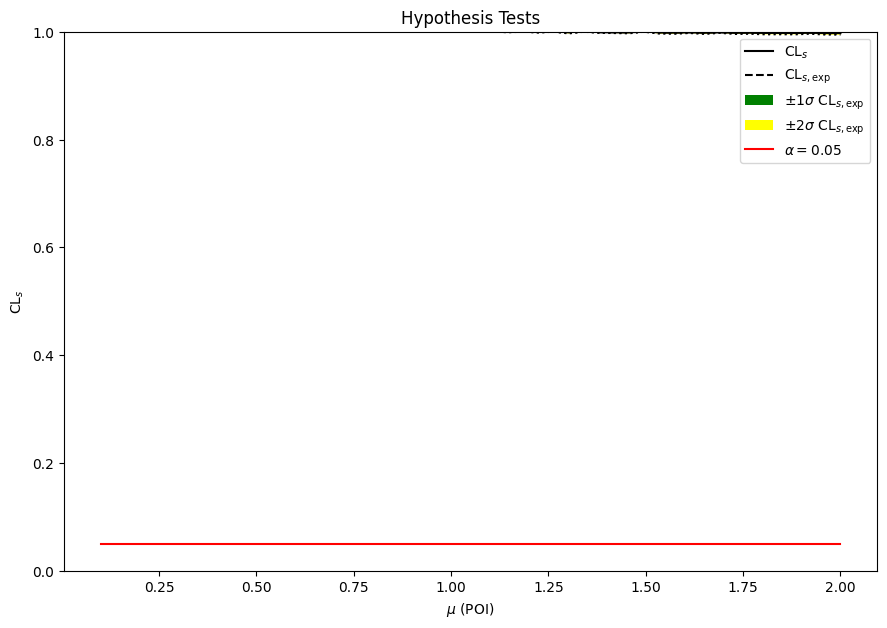

In [8]:
#Grafica de bandera
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7)
ax.set_title("Hypothesis Tests")

artists = brazil.plot_results(poi_values, results, ax=ax)